**Overview**

*   **Memory** is a cognitive function that allows AI agents to store, retrieve, and use information, which is crucial for efficiency and user satisfaction.
*   There are two main types of memory: **short-term** and **long-term**.
*   Memory enables agents to learn from feedback and adapt to user preferences.

**Short-Term Memory**

*   Short-term memory is **thread-scoped**, meaning it can be recalled within a single conversational thread.
*   LangGraph manages short-term memory as part of the agent's state, which is persisted to a database using a checkpointer, allowing threads to be resumed at any time.
*   Short-term memory is updated when the graph is invoked or a step is completed.
*   The agent's state includes conversation history, uploaded files, retrieved documents, and generated artifacts.
*   Managing short-term memory involves balancing precision and recall with application performance requirements.
*   Conversation history is a common form of short-term memory.
*   Techniques for managing long conversation history include:
    *   **Editing Message Lists**: Removing or filtering stale information by deleting old messages. This can be done by defining a reducer function that specifies which messages to keep or remove.
    *   **Summarizing Past Conversations**: Using a chat model to create summaries of the message history, which can then be used as context.
    *   **Knowing When to Remove Messages**: Truncating messages when the token limit is approached, using utilities like `trim_messages`.

**Long-Term Memory**

*   Long-term memory is shared **across** conversational threads and can be recalled at any time and in any thread.
*   It is saved within custom "namespaces," allowing for hierarchical organization of memories.
*   LangGraph stores long-term memories as JSON documents in a store, with each memory organized under a custom namespace and a distinct key.
*   Long-term memory can be used to store different types of memories, such as:
    *   **Semantic Memory**: Stores facts and concepts, often used to personalize applications by remembering information about a user. This can be managed as a single, continuously updated "profile," or as a collection of documents.
    *   **Episodic Memory**: Recalls past events or actions, often implemented through few-shot example prompting.
    *   **Procedural Memory**: Stores the rules used to perform tasks, which is often a combination of model weights, agent code, and agent's prompt. It is common for agents to modify their own prompts through "Reflection" or meta-prompting.

**Writing Memories**

*   There are two primary methods for agents to write memories:
    *   **Writing memories "on the hot path"**: Creating memories during runtime, which allows for real-time updates and transparency, but can increase complexity and latency.
    *   **Writing memories "in the background"**: Creating memories as a separate background task, which eliminates latency in the primary application and allows for more focused task completion, but requires careful timing of memory creation.

**Key Concepts**

*   **Namespaces**: Used to organize memories, often including user or organisation IDs.
*   **Reducers**: Functions used to define how memory is updated, such as adding or removing messages.
*   **Few-shot Learning**: Using past examples to teach a model by updating the prompt with input-output examples.
*    **Reflection/Meta-prompting**: The agent refines its instructions based on its current instructions and recent conversations or feedback.

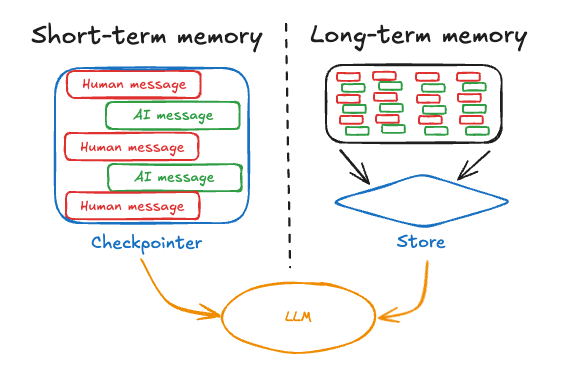
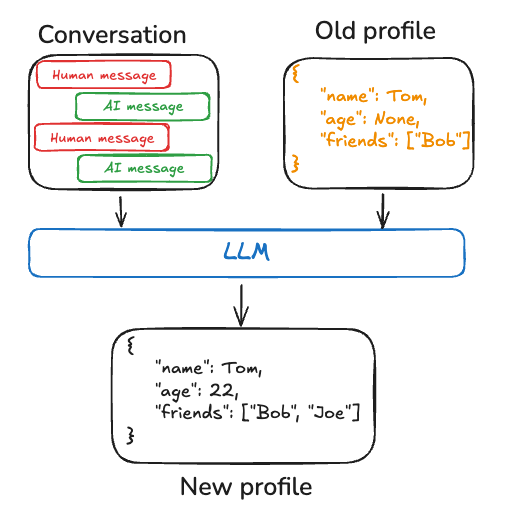
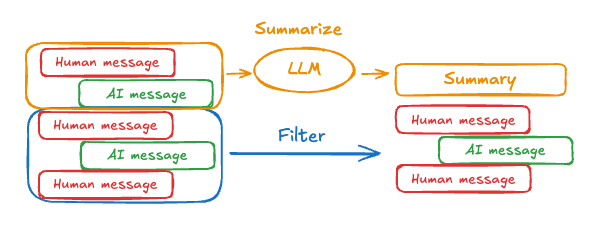
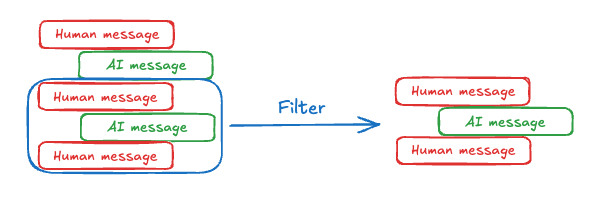
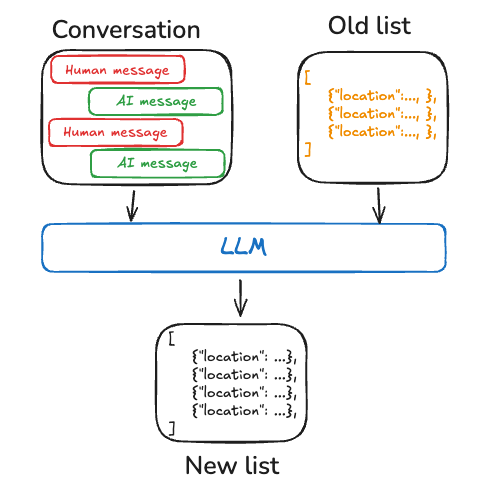
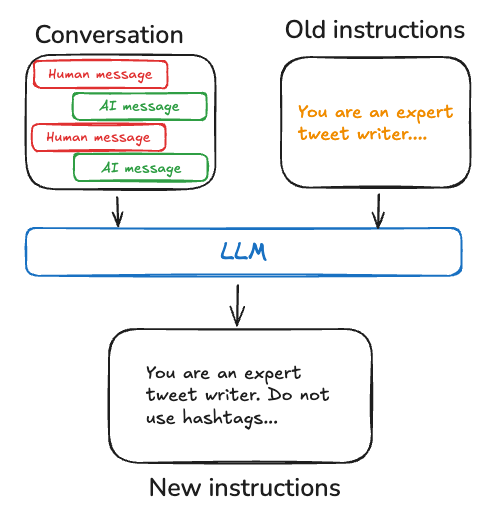
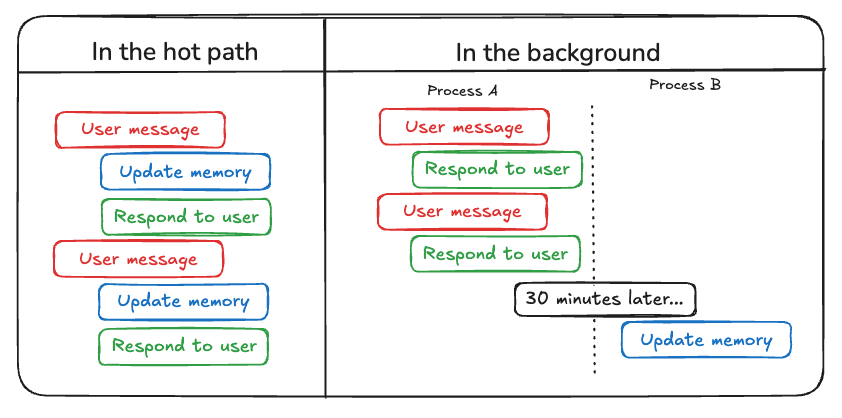



In [6]:
from dotenv import load_dotenv
load_dotenv("/home/sergii/.env")

True

In [7]:
from langchain_core.messages import trim_messages
from langchain_openai.chat_models import ChatOpenAI


trim_messages(
    'messages',
    # Keep the last <= n_count tokens of the messages.
    strategy="last",
    # Remember to adjust based on your model
    # or else pass a custom token_encoder
    token_counter=ChatOpenAI(model="gpt-4"),
    # Remember to adjust based on the desired conversation
    # length
    max_tokens=45,
    # Most chat models expect that chat history starts with either:
    # (1) a HumanMessage or
    # (2) a SystemMessage followed by a HumanMessage
    start_on="human",
    # Most chat models expect that chat history ends with either:
    # (1) a HumanMessage or
    # (2) a ToolMessage
    end_on=("human", "tool"),
    # Usually, we want to keep the SystemMessage
    # if it's present in the original history.
    # The SystemMessage has special instructions for the model.
    include_system=True,
)

[HumanMessage(content='m', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='e', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='s', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='s', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='a', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='g', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='e', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='s', additional_kwargs={}, response_metadata={})]

In [8]:
from langgraph.store.memory import InMemoryStore


def embed(texts: list[str]) -> list[list[float]]:
    # Replace with an actual embedding function or LangChain embeddings object
    return [[1.0, 2.0] * len(texts)]


# InMemoryStore saves data to an in-memory dictionary. Use a DB-backed store in production use.
store = InMemoryStore(index={"embed": embed, "dims": 2})
user_id = "my-user"
application_context = "chitchat"
namespace = (user_id, application_context)
store.put(
    namespace,
    "a-memory",
    {
        "rules": [
            "User likes short, direct language",
            "User only speaks English & python",
        ],
        "my-key": "my-value",
    },
)
# get the "memory" by ID
item = store.get(namespace, "a-memory")
# search for "memories" within this namespace, filtering on content equivalence, sorted by vector similarity
items = store.search(
    namespace, filter={"my-key": "my-value"}, query="language preferences"
)

In [9]:
store.list_namespaces()

[('my-user', 'chitchat')]

In [10]:
item

Item(namespace=['my-user', 'chitchat'], key='a-memory', value={'rules': ['User likes short, direct language', 'User only speaks English & python'], 'my-key': 'my-value'}, created_at='2024-12-18T07:06:17.209245+00:00', updated_at='2024-12-18T07:06:17.209250+00:00')

In [11]:
store._data

defaultdict(dict,
            {('my-user',
              'chitchat'): {'a-memory': Item(namespace=['my-user', 'chitchat'], key='a-memory', value={'rules': ['User likes short, direct language', 'User only speaks English & python'], 'my-key': 'my-value'}, created_at='2024-12-18T07:06:17.209245+00:00', updated_at='2024-12-18T07:06:17.209250+00:00')}})